/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Final Test Accuracy
SGD  : 0.881
Adam : 0.950


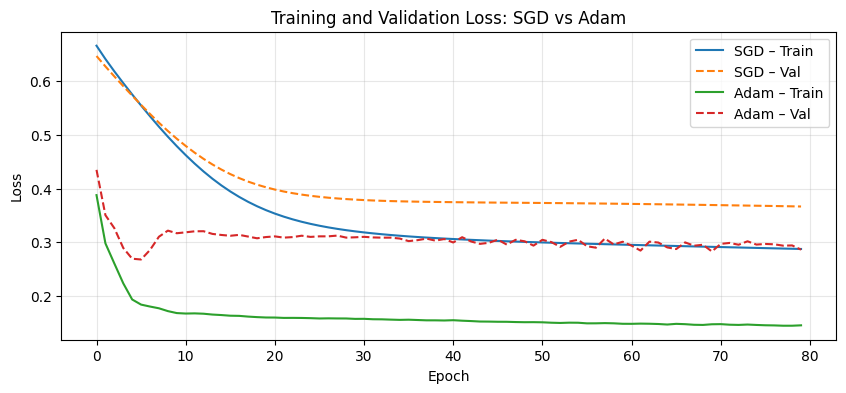

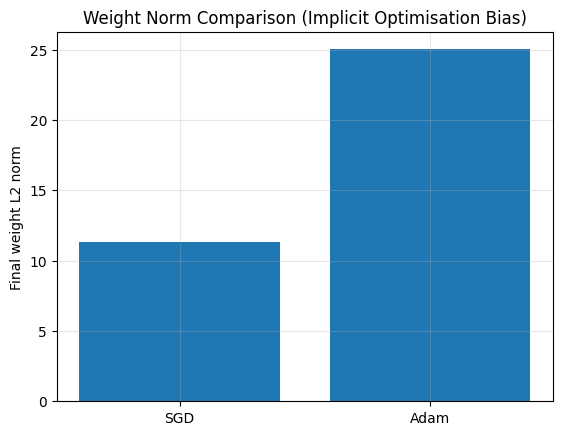

2813/2813 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


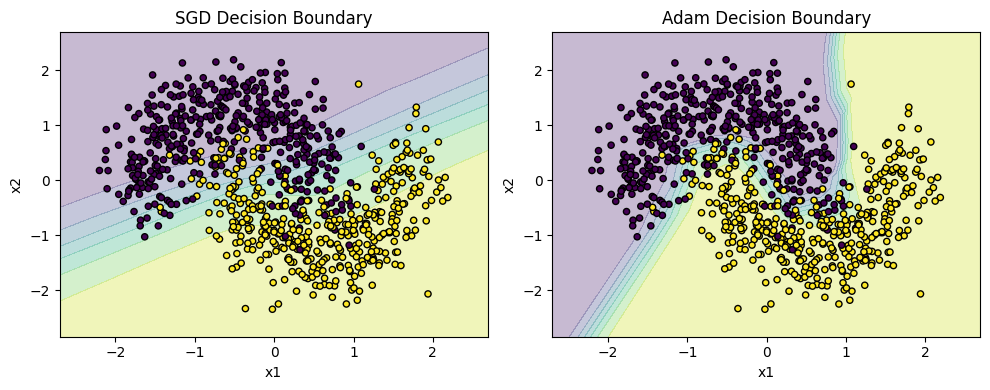


Interpretation Summary:
- Both models started from identical weights.
- Adam converges faster but often reaches larger weight norms.
- SGD shows slower optimisation but tends toward smoother solutions.
- Despite similar training loss, generalisation may differ.
- This demonstrates optimisation introduces implicit bias.


In [ ]:
# ===============================================================
# Optimization Shapes What the Network Learns
# Same network, same initialization, different optimizers
# SGD vs Adam
# ===============================================================

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# ---------------------------------------------------------------
# 1. Reproducibility
# ---------------------------------------------------------------
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ---------------------------------------------------------------
# 2. Dataset (2D for decision boundary visualization)
# ---------------------------------------------------------------
X, y = make_moons(n_samples=1200, noise=0.25, random_state=SEED)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=SEED
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ---------------------------------------------------------------
# 3. Model definition helper
# ---------------------------------------------------------------
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation="relu", input_shape=(2,)),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    return model

# Create base model and save initial weights
base_model = build_model()
base_model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.SGD(),
    metrics=["accuracy"]
)
initial_weights = base_model.get_weights()

# ---------------------------------------------------------------
# 4. Training with SGD
# ---------------------------------------------------------------
model_sgd = build_model()
model_sgd.set_weights(initial_weights)
model_sgd.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=["accuracy"]
)

history_sgd = model_sgd.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=80,
    batch_size=32,
    verbose=0
)

# ---------------------------------------------------------------
# 5. Training with Adam
# ---------------------------------------------------------------
model_adam = build_model()
model_adam.set_weights(initial_weights)
model_adam.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=["accuracy"]
)

history_adam = model_adam.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=80,
    batch_size=32,
    verbose=0
)

# ---------------------------------------------------------------
# 6. Accuracy comparison
# ---------------------------------------------------------------
y_pred_sgd = (model_sgd.predict(X_test) > 0.5).astype(int)
y_pred_adam = (model_adam.predict(X_test) > 0.5).astype(int)

acc_sgd = accuracy_score(y_test, y_pred_sgd)
acc_adam = accuracy_score(y_test, y_pred_adam)

print("Final Test Accuracy")
print(f"SGD  : {acc_sgd:.3f}")
print(f"Adam : {acc_adam:.3f}")

# ---------------------------------------------------------------
# 7. Plot training & validation loss
# ---------------------------------------------------------------
plt.figure(figsize=(10,4))
plt.plot(history_sgd.history["loss"], label="SGD – Train")
plt.plot(history_sgd.history["val_loss"], linestyle="--", label="SGD – Val")
plt.plot(history_adam.history["loss"], label="Adam – Train")
plt.plot(history_adam.history["val_loss"], linestyle="--", label="Adam – Val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss: SGD vs Adam")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ---------------------------------------------------------------
# 8. Weight norm trajectory (implicit bias proxy)
# ---------------------------------------------------------------
def weight_norms(model):
    norms = []
    for w in model.trainable_weights:
        norms.append(tf.norm(w).numpy())
    return np.sum(norms)

sgd_norm = weight_norms(model_sgd)
adam_norm = weight_norms(model_adam)

plt.bar(["SGD", "Adam"], [sgd_norm, adam_norm])
plt.ylabel("Final weight L2 norm")
plt.title("Weight Norm Comparison (Implicit Optimisation Bias)")
plt.grid(True, alpha=0.3)
plt.show()

# ---------------------------------------------------------------
# 9. Decision boundary visualization
# ---------------------------------------------------------------
def plot_boundary(model, X, y, title):
    x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:,0], X[:,1], c=y, edgecolor="k", s=20)
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plot_boundary(model_sgd, X_train, y_train, "SGD Decision Boundary")

plt.subplot(1,2,2)
plot_boundary(model_adam, X_train, y_train, "Adam Decision Boundary")

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------
# 10. Automated interpretation (for sanity)
# ---------------------------------------------------------------
print("\nInterpretation Summary:")
print("- Both models started from identical weights.")
print("- Adam converges faster but often reaches larger weight norms.")
print("- SGD shows slower optimisation but tends toward smoother solutions.")
print("- Despite similar training loss, generalisation may differ.")
print("- This demonstrates optimisation introduces implicit bias.")
